In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

import matplotlib.pyplot as plt
import pandas as pd
#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

mpl.rcParams['figure.figsize'] = [12., 12.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = '12'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [4]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='Exponential'
        self.parameters = ModelParameterArray()      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=10000,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=3,val_min=0.,val_max=10.,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [31]:
class LogisticModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticModel,self).__init__(  **keywords)
        self.name='LogisticModel'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=10000,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return self.N/(1+np.exp(-(nu-self.t_0)/self.tau))
    

In [6]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time

In [7]:
def get_data_jh(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19-JH/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>0
    
    #to get each time integer from 1 to N (rather than 0 N-1)
    #dates start from 1 not 0
    time=np.arange(1,len(t)+1)
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y').date)
    return data,df

def get_data_protezione_civile(name='deceduti',fake_error=False,regione=None):
    
    if regione is None:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
        df=table.to_pandas()
    else:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-regioni/dpc-covid19-ita-regioni.csv')
        df=table.to_pandas()
        df=df[df['denominazione_regione']==regione]
    t=df['data']
    t=pd.to_datetime(t)
    time=np.arange(1,len(t)+1)
    y=df[name]
    msk=y>0
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001

    data_table=Table([time[msk] , y[msk] , y_err[msk], np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,np.array(t.dt.date))

    return data,df


In [173]:
def plot_model(mcmc,model,data,t_start_model=None, t_stop_model=None, size=10,mcmc_samples=500, labels=None,label='',title=''):
    
    #fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(13,6),sharex='col')
    fig = plt.figure(constrained_layout=True,figsize=(8,10))

    widths = [1]
    heights = [1, .2, 1]
    spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths, height_ratios=heights,hspace=0.4)
    
    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1],sharex=ax1)
    ax3 = fig.add_subplot(spec[2],sharex=ax2)

    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    #nu=np.linspace(t_start_model,t_stop_model,100)
    nu=np.arange(t_start_model,t_stop_model,1)
    
    if hasattr(model,'Exponential'):
        p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    
    if mcmc is not None:
        mcmc.reset_to_best_fit()
        y = np.zeros((size,nu.size))

        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            for ID_par,pi in  enumerate(mcmc.par_array):
                pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])

            y[ID] = model.eval(nu,get_model=True)

        #print(ID)
        y_min=np.amin(y, axis=0)
        y_max=np.amax(y, axis=0)
        ax1.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)

        mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    if hasattr(model,'Exponential'):
        txt=': Predicted\nlog10(R0)/tau=%3.3f'%p
    else:
        txt=': Predicted'
    ax1.plot(nu,y_bf,label= label+txt)
    
    ax1.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    ax1.axvline(model.nu_min_fit,alpha=0.5)
    ax1.axvline(model.nu_max_fit,alpha=0.5)
    
    
    locs, labels = plt.xticks()
    #add 100 days to final date in data
    delta_t=pd.date_range(data.time[-1], periods=100, freq='d')[1:]
    t=np.append(data.time,delta_t.date)
    delta_x=data.data['nu_data'][-1]+np.arange(1,len(t)-len(data.data['nu_data'])+1)
    #sfit letf by 1 to align time with x thicks 
    x=np.append(data.data['nu_data'],delta_x)-1
    #print(len(t),len(x))
    #ids=np.arange(0,x.size,2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(t,rotation=45)
    #axs[0].set_xlabel('date')
    ax1.set_ylabel('Counts')
    ax1.semilogy()
    #ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    ax1.legend(loc='best')
    #axs[0].legend()
    ax1.set_xlim(t_start_model-1,None)
    ax1.get_xaxis().set_visible(False)
    #axs[0].set_ylim(1E-3,None)
    #axs[0].grid(True)
    #axs[1].semilogy(np.gradient(bfm.fit_Model.eval(nu,get_model=True)),label='model')
  
    ax2.set_xticklabels(t,rotation=45)
    x_res,y_res=model.get_residuals(log_log=False,data=data.data)
    msk1 = x_res<model.nu_max_fit
    msk2 =x_res>model.nu_min_fit
    x_res=x_res[msk1*msk2]
    y_res=y_res[msk1*msk2]
    line = ax2.errorbar(x_res, y_res, yerr=np.ones(x_res.size), fmt='+')
    ax2.axhline(0,ls='--',alpha=0.5)
    
    #Model
    ax3.plot(nu  ,np.gradient(y_bf,nu,edge_order=2 ),label='model')
   
    if mcmc is not None:
        y_der = np.zeros((size,nu.size))
        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            y_der[ID] = np.gradient(y[ID],nu,edge_order=2) 
        
        y_min=np.amin(y_der, axis=0)
        y_max=np.amax(y_der, axis=0)    
        ax3.fill_between(nu ,y_max  ,y_min  ,color='gray',alpha=0.3)
    
    ax3.plot(data.data['nu_data']  ,np.gradient(data.data['nuFnu_data'],data.data['nu_data']),'o',label='data')
    
    ax3.axvline(model.nu_min_fit,alpha=0.5)
    ax3.axvline(model.nu_max_fit,alpha=0.5)    
    ax3.semilogy()
    ax3.set_xticklabels(t,rotation=45)
    ax3.set_xlabel('date')
    ax3.set_ylabel('derivative')
    #ax3.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    ax3.legend(loc='best')
    plt.tight_layout()
    fig.suptitle(title,y=1.02)
    
    
    #plt.subplots_adjust(hspace=.0)
    return fig

In [9]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [128]:
def do_analysis(model,data,t_start,t_stop,t_start_model,t_stop_model,name,do_plot=True,do_mcmc=True,mcmc_steps=500,title=''):


    model.nu_min=0
    model.nu_max=100
    #Fix error on the last entry of the latest update of JH database
    
    fm=FitModel(analytical=model,name='test')
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    
    if hasattr(model,'R0'):
        log_R0_by_tau=np.log10(model.parameters.R0.val)/model.parameters.tau.val
        print('log10(R0)/tau',log_R0_by_tau)
        print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
    if do_mcmc is True:
        mcmc=McmcSampler(bfm)
        mcmc.run_sampler(nwalkers=150,burnin=10,steps=mcmc_steps,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)
    else:
        mcmc = None
    if do_plot is True:
        fig=plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start,t_stop_model= t_stop_model,label=name,size=100,mcmc_samples=100,title=title
                      )
            
        
        
        
        

    return bfm,mcmc,data,fig

  1%|          | 6/500 [00:00<00:08, 57.92it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 6.923059e+03 8.439739e+03    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
LogisticModel  tau 3.189016e+00 1.262695e-01    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
LogisticModel  t_0 2.337873e+01 4.382704e+00    -- 1.000000e+01 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:08<00:00, 60.32it/s]


mcmc run done, with 1 threads took 8.31 seconds


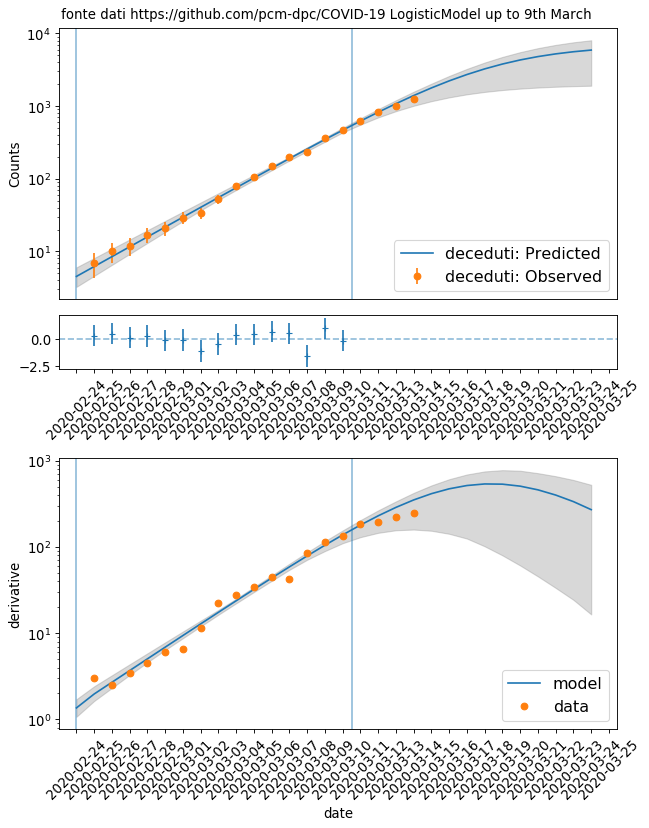

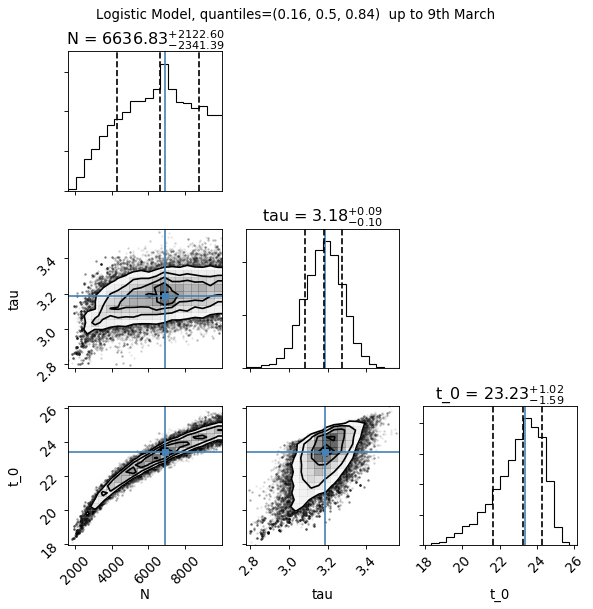

In [174]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
lm=LogisticModel()
lm.parameters.t_0.val=10
bfm,mcmc,data,fig=do_analysis(lm,data,t_start=0,t_stop=15.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s up to 9th March'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s  up to 9th March'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()

  1%|          | 6/500 [00:00<00:09, 53.10it/s]

log10(R0)/tau 0.1330378975102343
doubling time 2.26273867294711
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 1.342858e-02 6.620150e-03    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
GrowthModel   R0 2.658759e+00 6.174963e+00    -- 3.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 3.192165e+00 6.324347e+00    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 8.976188e+00 1.611794e+00    -- 1.000000e+01 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.20it/s]


mcmc run done, with 1 threads took 9.25 seconds


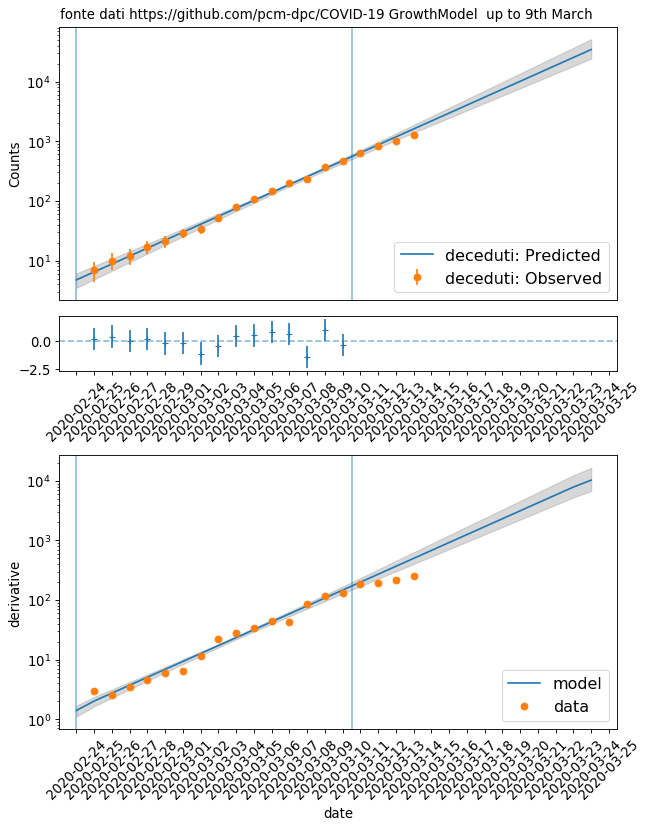

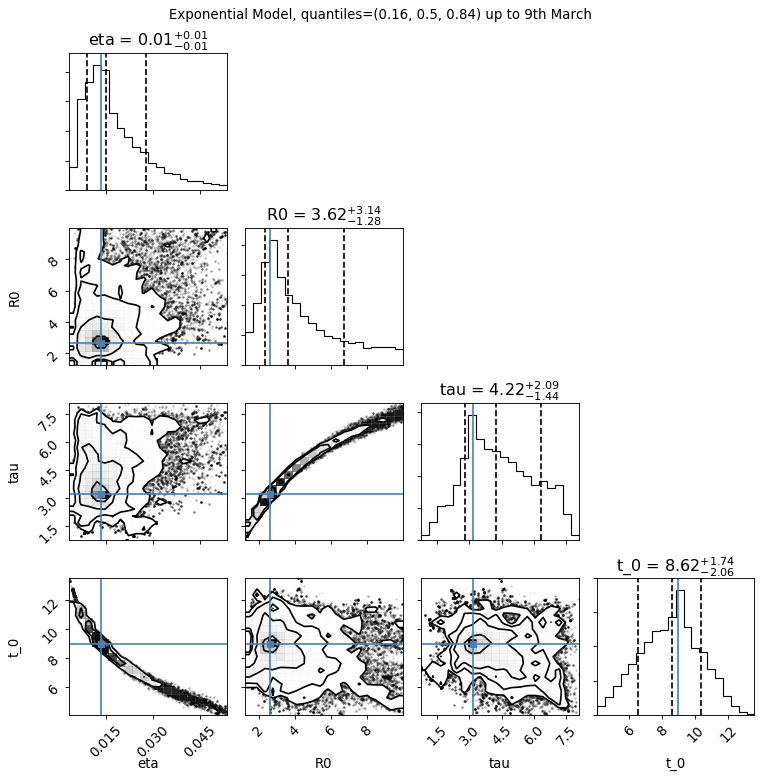

In [175]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
gm=GrowthModel()
gm.parameters.t_0.val=10
bfm,mcmc,data,fig=do_analysis(gm,data,t_start=0,t_stop=15.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s  up to 9th March'%gm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Exponential Model, quantiles=%s up to 9th March'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()

  1%|          | 6/500 [00:00<00:08, 55.16it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 3.545004e+03 6.776525e+02    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
LogisticModel  tau 3.077725e+00 9.727374e-02    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
LogisticModel  t_0 2.077628e+01 8.958771e-01    -- 1.000000e+01 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 53.04it/s]


mcmc run done, with 1 threads took 9.45 seconds


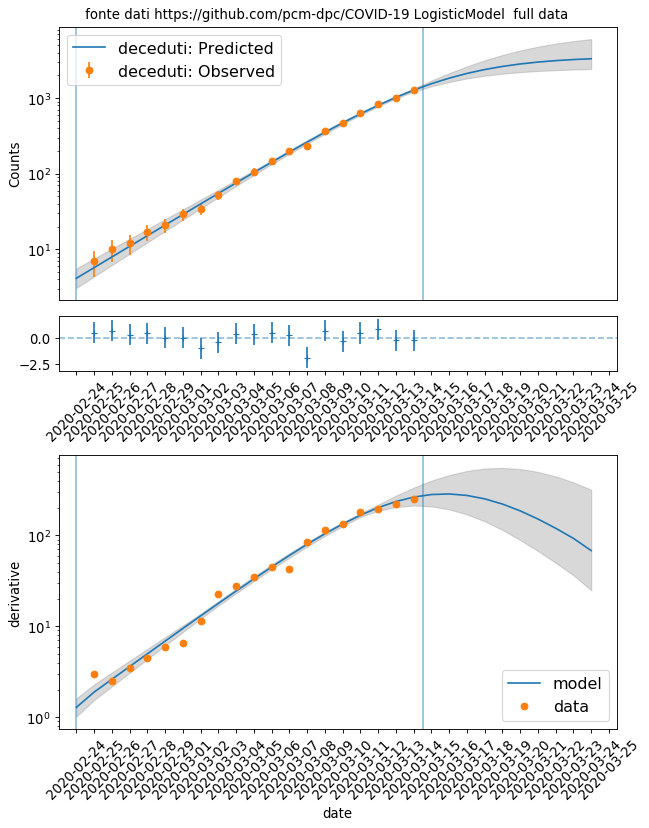

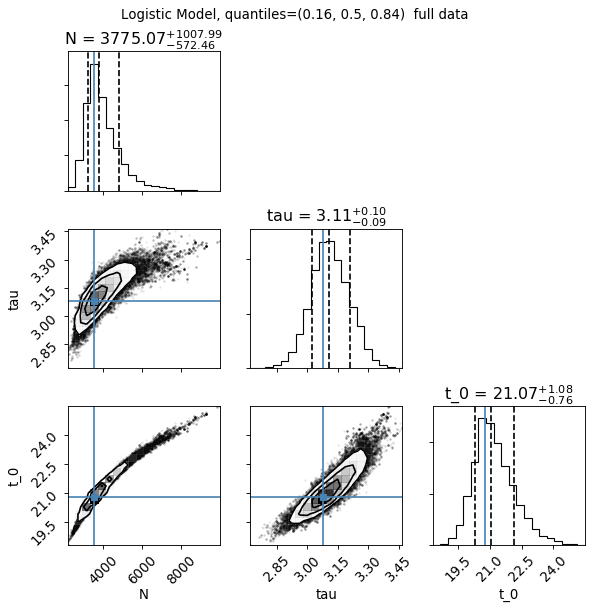

In [176]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
lm=LogisticModel()
lm.parameters.t_0.val=10
bfm,mcmc,data,fig=do_analysis(lm,data,t_start=0,t_stop=19.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s  full data'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s  full data'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()

  1%|          | 6/500 [00:00<00:08, 56.06it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 3.545004e+03 6.776525e+02    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
LogisticModel  tau 3.077725e+00 9.727374e-02    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
LogisticModel  t_0 2.077628e+01 8.958771e-01    -- 1.000000e+01 -3.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.88it/s]


mcmc run done, with 1 threads took 9.13 seconds


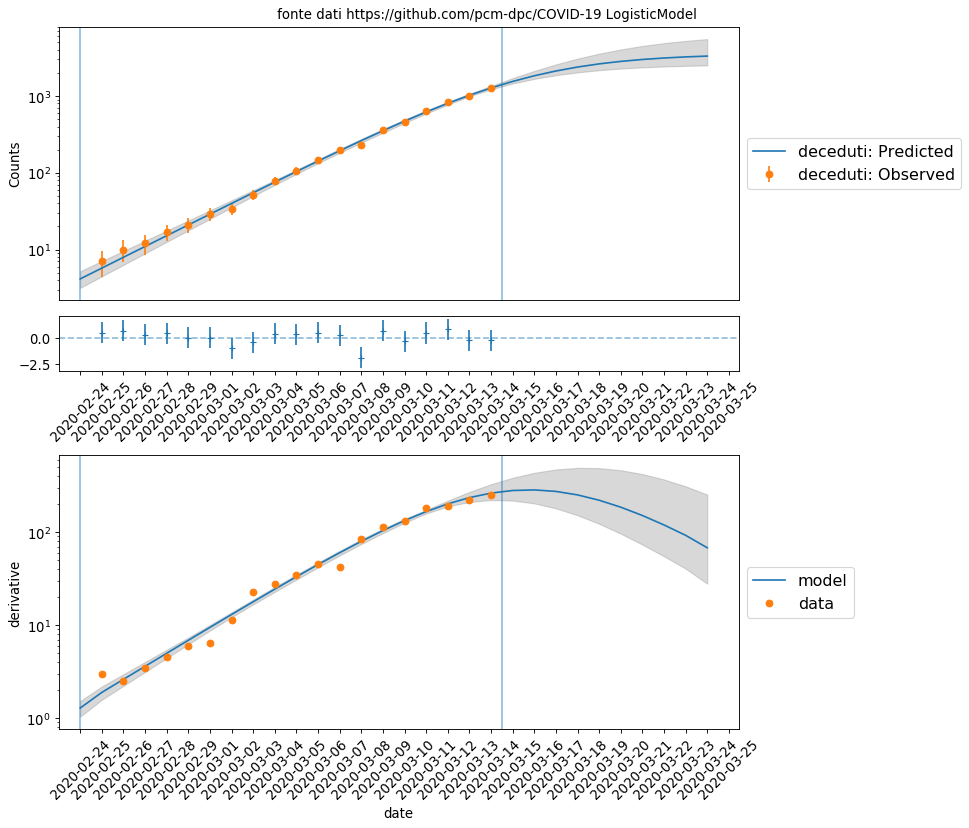

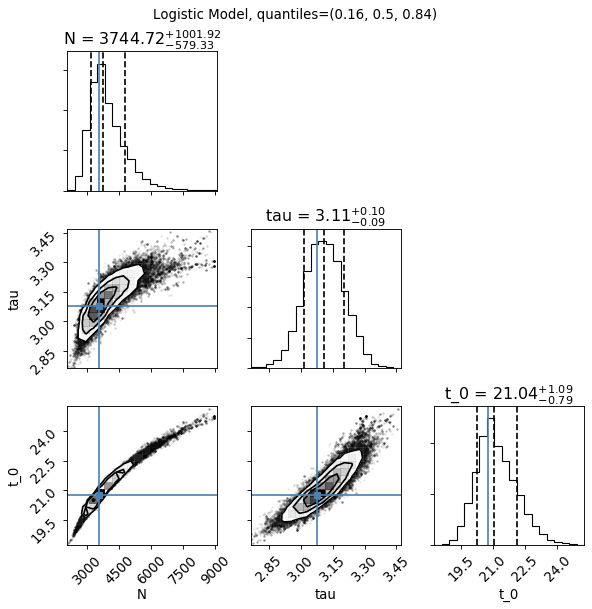

In [164]:
name='deceduti'
data,df =get_data_protezione_civile(name,fake_error=False)
lm=LogisticModel()
lm.parameters.t_0.val=10
bfm,mcmc,data,fig=do_analysis(lm,data,t_start=0,t_stop=19.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%lm.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('Logistic Model, quantiles=%s'%str((0.16,0.5,0.84)),y=1.01)
plt.tight_layout()

In [177]:
name='terapia_intensiva'
data,df =get_data_protezione_civile(name,fake_error=False,regione='Lombardia')


Text(0.5, 1.0, 'Lombardia')

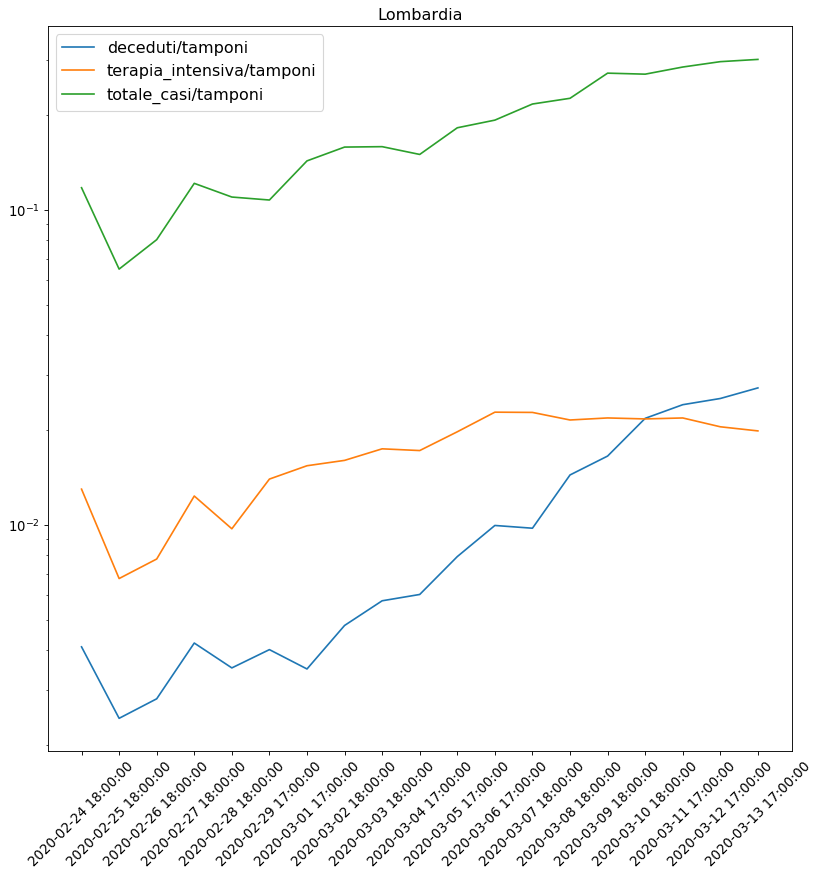

In [178]:
name='terapia_intensiva'
data,df =get_data_protezione_civile(name,fake_error=False,regione='Lombardia')

plt.plot(df['data'],df['deceduti']/df['tamponi'],label='deceduti/tamponi')
plt.plot(df['data'],df['terapia_intensiva']/df['tamponi'],label='terapia_intensiva/tamponi')
plt.plot(df['data'],df['totale_casi']/df['tamponi'],label='totale_casi/tamponi')
plt.semilogy()
plt.xticks(rotation=45)
plt.legend()
plt.title('Lombardia')

Text(0.5, 1.0, 'Italia')

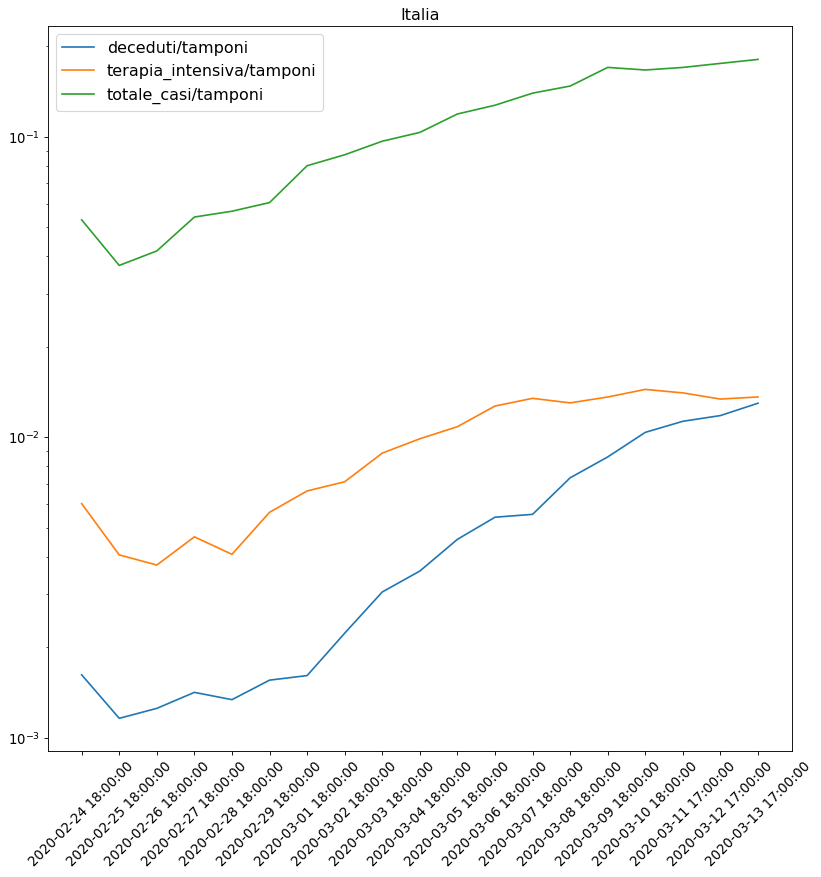

In [179]:
name='terapia_intensiva'
data,df =get_data_protezione_civile(name,fake_error=False,regione=None)

plt.plot(df['data'],df['deceduti']/df['tamponi'],label='deceduti/tamponi')
plt.plot(df['data'],df['terapia_intensiva']/df['tamponi'],label='terapia_intensiva/tamponi')
plt.plot(df['data'],df['totale_casi']/df['tamponi'],label='totale_casi/tamponi')
plt.semilogy()
plt.xticks(rotation=45)
plt.legend()
plt.title('Italia')

In [180]:
1.4/8.4

0.16666666666666666

In [181]:
fig = plt.figure(constrained_layout=True,figsize=(13,6))
widths = [1]
heights = [1, .2, 1]
spec5 = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths,
                          height_ratios=heights)

<Figure size 1040x480 with 0 Axes>

In [182]:
 ax1 = fig.add_subplot(spec5[0])
 ax2 = fig.add_subplot(spec5[0],sharex=ax1)
 ax3 = fig.add_subplot(spec5[0],sharex=ax2)


In [ ]:
plt.plot()

[]